In [10]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import matplotlib
from matplotlib.pyplot import plot
from epyt import epanet

inp_file_path = 'D:\\Desktop\\222.inp'
G = epanet(inp_file_path)
inp = open(inp_file_path, 'r')
inp_text = np.array(inp.readlines())
begin = np.argwhere(inp_text=='[PIPES]\n')[0][0] + 1

def evaluate_Kw(Kw_values):
    
    # 步骤 2b: 根据管段的 Description 设置不同的 Kw 值
    def get_pipe_description(link_index):
        return eval(inp_text[begin+link_index].split(';',-1)[-1][:-1])

    for link_index in range(1, G.getLinkCount() + 1):
        link_description = get_pipe_description(link_index)  # 获取管段的描述值GG
        if link_description == 10:
            G.setLinkWallReactionCoeff(link_index, Kw_values[0]) # 设置管段的 Kw 值
        elif link_description == 20:
            G.setLinkWallReactionCoeff(link_index, Kw_values[1])  # 设置管段的 Kw 值


    # 设置统一的 Kb 值
    unified_Kb = -0.2  # 设置为固定的 Kb 值，替换为需要的值
    for link_index in range(1, G.getLinkCount() + 1):
        G.setLinkBulkReactionCoeff(link_index, unified_Kb)  # 设置统一的 Kb 值

    # 步骤 2c: 使用 epyt 模拟水质传输并获取模拟结果
    simulated_data = []  # 用于存储模拟结果的列表
    monitored_nodes = ['3','7','10', '12','14', '19','21','24','29', '30', '36','34',]  # 实际监测点的 ID，需要根据模型中的节点 ID 来指定

    for node_id in monitored_nodes:
        node_index = G.getNodeIndex(node_id)  # 获取节点在 EPANET 模型中的索引
        G.solveCompleteHydraulics()  # 解决水力模型
        G.solveCompleteQuality()  # 解决水质模型
        node_quality = G.getNodeActualQuality(node_index)  # 获取节点的实际水质
        simulated_data.append(node_quality)  # 将模拟结果添加到列表中

    # 步骤 2d: 计算模拟结果与手动设置的实测水质数据之间的误差
    def calculate_error(simulated_data, manual_measurement_data):
        # 在这里，您可以使用均方误差（MSE）作为误差计算方法
        mse = np.mean(np.square(np.array(simulated_data) - np.array(list(manual_measurement_data.values()))))
        return mse

    manual_measurement_data = {
        '3' : 0.9,
        '7' : 0.84,
        '10': 0.62,  # 替换为实测余氯浓度值
        '12': 0.69,  # 替换为实测余氯浓度值
        '14': 0.97,
        '19': 0.72,
        '21': 0.76,
        '24': 0.98,
        '29': 0.90,
        '30': 0.46,  # 替换为实测余氯浓度值
        '36': 0.55,  # 替换为实测余氯浓度值
        '34': 0.54  # 替换为实测余氯浓度值
          # 替换为实测余氯浓度值
    }

    error = calculate_error(simulated_data, manual_measurement_data)  # 计算模拟误差
    return error  # 返回误差值作为优化目标

EPANET version 20200 loaded (EPyT version 1.0.6).
Input File 222.inp loaded successfully.



In [11]:
# 步骤 3: 设置 Kw 值的搜索范围
min_Kw1 = -1.0  # Kw1 的最小值
max_Kw1 = 0.0  # Kw1 的最大值
min_Kw2 = -1.0  # Kw2 的最小值
max_Kw2 = 0.0  # Kw2 的最大值


# 步骤 4: 设置遗传算法参数
varbound_Kw = np.array([[min_Kw1, max_Kw1], [min_Kw2, max_Kw2]])  # 定义 Kw1、Kw2、Kw3 的搜索范围

algorithm_param = {
    'max_num_iteration': 3000,  # 最大迭代次数
    'population_size': 100,  # 种群大小
    'mutation_probability': 0.3,  # 变异概率
    'crossover_probability': 0.8,  # 交叉概率
    'variable_type': 'real',  # 变量类型为实数型
    'variable_boundaries': varbound_Kw,  # 变量搜索范围，只优化 Kw 值，不包括 Kb
    'parents_portion': 0.1,  # 设置每代保留的上一代个体数量的比例
    'elit_ratio': 0.01,  # 设置每代中保留的精英个体的比例
    'crossover_type': 'uniform',  # 设置交叉类型为 'two_point'
    'max_iteration_without_improv': 200,  # 设置多次没有提升后提前终止迭代的次数
}

 The best solution found:                                                                           
 [-0.05522452 -0.05955341]

 Objective function:
 7.852868083545e-06


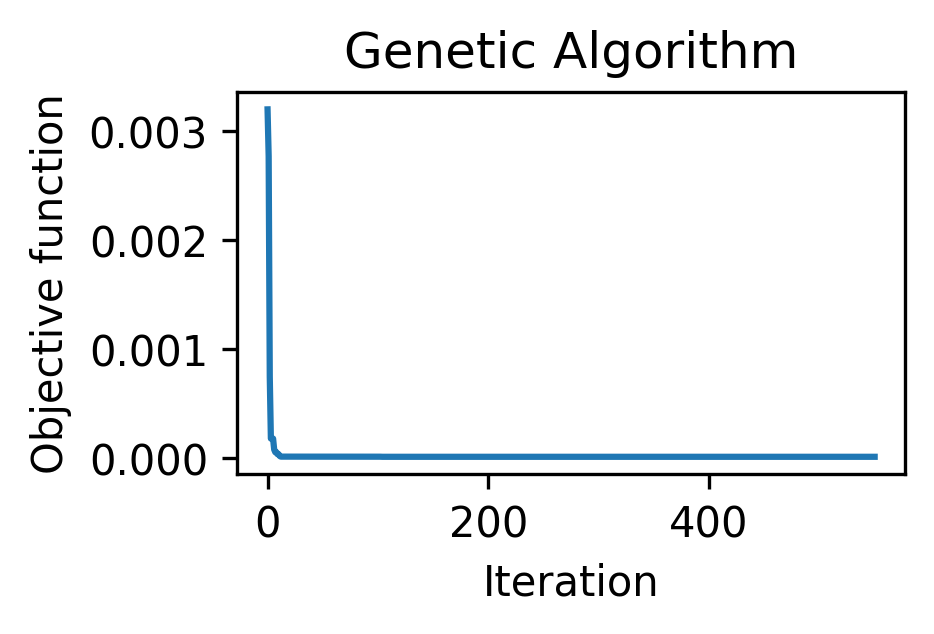

In [12]:
# 步骤 5: 执行遗传算法优化
model = ga(function=evaluate_Kw, dimension=2, variable_type='real', variable_boundaries=varbound_Kw,
           algorithm_parameters=algorithm_param)
model.run()
